### 2. Spatial Ops

In [57]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
import pathlib

from pyproj import Proj
from shapely.ops import nearest_points
from shapely.geometry import LineString

In [64]:
os.chdir('..')
path = pathlib.Path().resolve()

#### 1. Spatial joins 

1.1. Load data

In [2]:
countries = gpd.read_file(f'{path}/data/countries.shp')
conflicts = gpd.read_file(f'{path}/data/acled2019.shp')

In [3]:
countries.head()

,NAME,POP_EST,GDP_MD_EST,POP_YEAR,LASTCENSUS,GDP_YEAR,ECONOMY,INCOME_GRP,CONTINENT,REGION_UN,SUBREGION,geometry
0,Indonesia,260580739,3028000.0,2017,2010,2016,4. Emerging region: MIKT,4. Lower middle income,Asia,Asia,South-Eastern Asia,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Malaysia,31381992,863000.0,2017,2010,2016,6. Developing region,3. Upper middle income,Asia,Asia,South-Eastern Asia,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Chile,17789267,436100.0,2017,2002,2016,5. Emerging region: G20,3. Upper middle income,South America,Americas,South America,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Bolivia,11138234,78350.0,2017,2001,2016,5. Emerging region: G20,4. Lower middle income,South America,Americas,South America,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Peru,31036656,410400.0,2017,2007,2016,5. Emerging region: G20,3. Upper middle income,South America,Americas,South America,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


In [4]:
conflicts.head()

,data_id,iso,event_id_c,event_id_n,event_date,year,time_preci,event_type,sub_event_,actor1,...,latitude,longitude,geo_precis,source,source_sca,notes,fatalities,timestamp,iso3,geometry
0,6768128,887,YEM45982,45982,31 December 2019,2019,1,Battles,Armed clash,Military Forces of Yemen (2012-),...,14.3541,47.0765,2,Yemen Data Project; Aden al Ghad; Al Janoob al...,Local partner-National,"On 31 December 2019, clashes reportedly erupte...",0,1580761030,YEM,POINT (47.07650 14.35410)
1,6768129,887,YEM45983,45983,31 December 2019,2019,1,Strategic developments,Change to group/activity,Military Forces of Yemen (2012-) Security Belt...,...,14.3541,47.0765,2,Al Janoob al Youm; Yemen Data Project,Local partner-National,"On 31 December 2019, forces loyal to the South...",0,1580761030,YEM,POINT (47.07650 14.35410)
2,6768130,887,YEM45984,45984,31 December 2019,2019,1,Battles,Armed clash,Military Forces of Yemen (2012-),...,14.2081,47.1570,1,Al Janoob al Youm; Aden al Ghad; Yemen Data Pr...,Local partner-National,"On 31 December 2019, clashes reportedly erupte...",1,1580761030,YEM,POINT (47.15700 14.20810)
3,6715395,356,IND68948,68948,31 December 2019,2019,1,Protests,Peaceful protest,Protesters (India),...,20.2724,85.8338,1,Pioneer (India),National,"On 31 December, students' wing of INC and Mili...",0,1578514389,IND,POINT (85.83380 20.27240)
4,6943236,222,SLV861,861,31 December 2019,2019,1,Violence against civilians,Attack,B-18: Barrio-18,...,13.5894,-89.2383,1,El Salvador.com,National,On 31th December 2019 in Huizucar (La Libertad...,1,1582839958,SLV,POINT (-89.23830 13.58940)


1.2. Regular Pandas merge

In [7]:
country_shapes = countries[['geometry','NAME']]
country_names = countries[['NAME','POP_EST']]

It is regular Pandas merge. 

In [10]:
merged = country_shapes.merge(country_names, on = 'NAME')
merged.head()

,geometry,NAME,POP_EST
0,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",Indonesia,260580739
1,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",Malaysia,31381992
2,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",Chile,17789267
3,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",Bolivia,11138234
4,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",Peru,31036656


In [11]:
type(merged)

geopandas.geodataframe.GeoDataFrame

1.3. Spatial join
- method used is `.sjoin`

In [14]:
merged.columns

Index(['geometry', 'NAME', 'POP_EST'], dtype='object')

In [15]:
conflicts.columns

Index(['data_id', 'iso', 'event_id_c', 'event_id_n', 'event_date', 'year',
       'time_preci', 'event_type', 'sub_event_', 'actor1', 'assoc_acto',
       'inter1', 'actor2', 'assoc_ac_1', 'inter2', 'interactio', 'region',
       'country', 'admin1', 'admin2', 'admin3', 'location', 'latitude',
       'longitude', 'geo_precis', 'source', 'source_sca', 'notes',
       'fatalities', 'timestamp', 'iso3', 'geometry'],
      dtype='object')

- In the `sjoin` function we need to specify two GeoPandas dataframes.
- `op` means `opstring` 
- object.within(other) Returns True if the object’s boundary and interior intersect only with the interior of the other (not its boundary or exterior).
- In our case means that takes conflict point that are within a countires polygon. If we use `op=contain` and find out which countries contain the city points. 

In [16]:
conflicts_in_countries = gpd.sjoin(conflicts, country_shapes, how='inner', op='within')

/opt/anaconda3/envs/spatial-ds-ws/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [17]:
conflicts_in_countries

,data_id,iso,event_id_c,event_id_n,event_date,year,time_preci,event_type,sub_event_,actor1,...,geo_precis,source,source_sca,notes,fatalities,timestamp,iso3,geometry,index_right,NAME
0,6768128,887,YEM45982,45982,31 December 2019,2019,1,Battles,Armed clash,Military Forces of Yemen (2012-),...,2,Yemen Data Project; Aden al Ghad; Al Janoob al...,Local partner-National,"On 31 December 2019, clashes reportedly erupte...",0,1580761030,YEM,POINT (47.07650 14.35410),161,Yemen
1,6768129,887,YEM45983,45983,31 December 2019,2019,1,Strategic developments,Change to group/activity,Military Forces of Yemen (2012-) Security Belt...,...,2,Al Janoob al Youm; Yemen Data Project,Local partner-National,"On 31 December 2019, forces loyal to the South...",0,1580761030,YEM,POINT (47.07650 14.35410),161,Yemen
2,6768130,887,YEM45984,45984,31 December 2019,2019,1,Battles,Armed clash,Military Forces of Yemen (2012-),...,1,Al Janoob al Youm; Aden al Ghad; Yemen Data Pr...,Local partner-National,"On 31 December 2019, clashes reportedly erupte...",1,1580761030,YEM,POINT (47.15700 14.20810),161,Yemen
15,6760978,887,YEM45977,45977,31 December 2019,2019,1,Strategic developments,Change to group/activity,Operation Restoring Hope,...,1,YNP; Yemen Data Project; Al Masdar,Local partner-National,"On 31 December 2019, Sudanese forces reportedl...",0,1580153672,YEM,POINT (46.67110 14.94030),161,Yemen
35,6711837,887,YEM45956,45956,31 December 2019,2019,1,Protests,Peaceful protest,Protesters (Yemen),...,1,Aden al Ghad,Subnational,"On 31 December, students from the Aden Communi...",0,1578511259,YEM,POINT (44.99050 12.88530),161,Yemen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182389,6226968,196,CYP114,114,01 February 2019,2019,1,Strategic developments,Change to group/activity,Military Forces of Turkey (2016-),...,2,Cyprus News Agency; To Vima; Ekathimerini; Har...,National-Regional,"On Feb. 1 2019, Turkish military forces moved ...",0,1572403605,CYP,POINT (33.90000 35.09500),6,Dhekelia
159163,6722068,226,EQG60,60,15 March 2019,2019,3,Violence against civilians,Attack,Police Forces of Equatorial Guinea (1979-) Pri...,...,1,Diario Rombe,National,Month of March. Police forces torture a Camero...,1,1579553202,GNQ,POINT (8.78330 3.75000),163,Eq. Guinea
167924,6722069,226,EQG59,59,27 February 2019,2019,1,Violence against civilians,Attack,Military Forces of Equatorial Guinea (1979-),...,1,Diario Rombe,National,"27 February. A critical journalist, Paysa Elo ...",0,1579553202,GNQ,POINT (8.78330 3.75000),163,Eq. Guinea
183413,6722078,226,EQG58,58,30 January 2019,2019,1,Protests,Peaceful protest,Protesters (Equatorial Guinea),...,1,Jeune Afrique,Regional,30 January. Protesters with the CPDS hang post...,0,1579553202,GNQ,POINT (8.78330 3.75000),163,Eq. Guinea


### 2. Buffer analysis 

- proximity analysis
- to get distance around a point / line / polygon 
- important to keep knowledge about CRS/projection 

2.1.Finding centroid of polygons

In [19]:
country_centroids = countries.geometry.centroid
country_centroids.head()

/var/folders/2f/c6skwjt96m984f45rzp9_qw40000gn/T/ipykernel_89987/786244657.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_centroids = countries.geometry.centroid


0     POINT (117.27043 -2.22296)
1      POINT (109.69887 3.79239)
2    POINT (-71.36437 -37.74361)
3    POINT (-64.68475 -16.70688)
4     POINT (-74.37806 -9.15439)
dtype: geometry

Each dot will represent a center of the country: 

<AxesSubplot: >

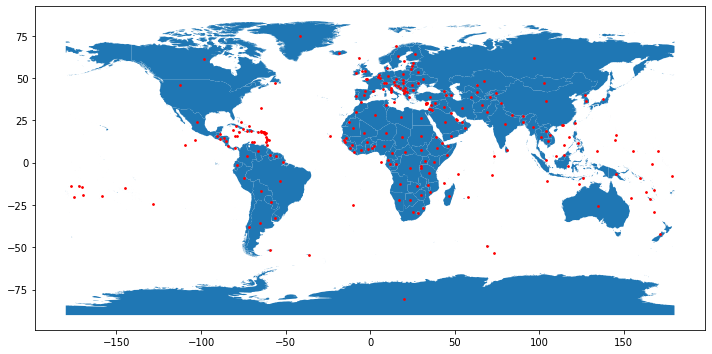

In [23]:
fig, ax = plt.subplots(figsize=(12,10))
countries.plot(ax=ax)
country_centroids.plot(ax=ax, color='red', markersize=3)

<AxesSubplot: >

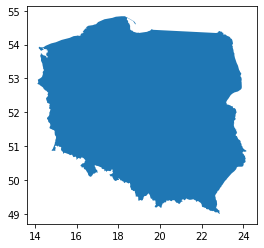

In [24]:
poland = countries[countries.NAME == 'Poland']
poland.plot()

In [25]:
poland.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
center_point_poland = poland.geometry.centroid 
center_point_poland

/var/folders/2f/c6skwjt96m984f45rzp9_qw40000gn/T/ipykernel_89987/1955442022.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_point_poland = poland.geometry.centroid


77    POINT (19.39432 52.12477)
dtype: geometry

In [28]:
center_point_poland.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

On this type of data calculating distance would be difficult, it depends on the CRS
- below we creating buffers with 1 and 2 degree distances


/var/folders/2f/c6skwjt96m984f45rzp9_qw40000gn/T/ipykernel_89987/1639724299.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poland_centroids_1_degree = center_point_poland.buffer(1)
/var/folders/2f/c6skwjt96m984f45rzp9_qw40000gn/T/ipykernel_89987/1639724299.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poland_centroids_2_degree = center_point_poland.buffer(2)


<AxesSubplot: >

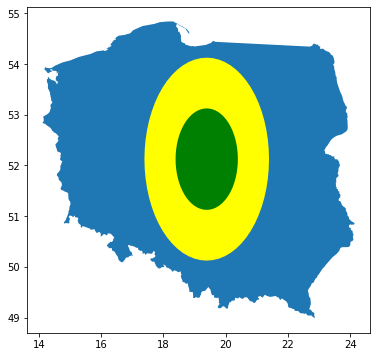

In [32]:
poland_centroids_1_degree = center_point_poland.buffer(1)
poland_centroids_2_degree = center_point_poland.buffer(2)

fig, ax = plt.subplots(figsize=(8,6)) 
poland.plot(ax=ax)
poland_centroids_2_degree.plot(ax=ax, color='yellow')
poland_centroids_1_degree.plot(ax=ax, color='green')

If we need calculations to be in meters we need to project the data. 

In [35]:
center_point_poland = center_point_poland.to_crs({'init':'epsg:2180'})
poland_projected = poland.to_crs({'init':'epsg:2180'})

/opt/anaconda3/envs/spatial-ds-ws/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [36]:
poland_projected.crs

<Derived Projected CRS: +init=epsg:2180 +type=crs>
Name: ETRF2000-PL / CS92
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Poland - onshore and offshore.
- bounds: (14.14, 49.0, 24.15, 55.93)
Coordinate Operation:
- name: Poland CS92
- method: Transverse Mercator
Datum: ETRF2000 Poland
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

It is projection based on meters

Create buffers of 20 and 50km 

In [37]:
poland_centre_20km = center_point_poland.buffer(20000)
poland_centre_50km = center_point_poland.buffer(50000)

<AxesSubplot: >

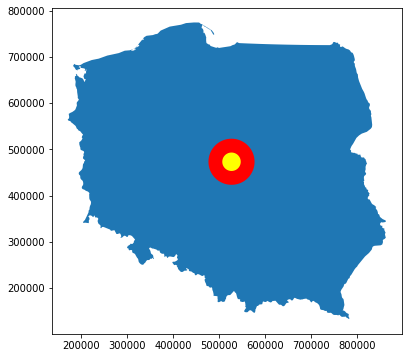

In [40]:
fix, ax = plt.subplots(figsize=(8,6)) 

poland_projected.plot(ax=ax)
poland_centre_50km.plot(ax=ax, color='red')
poland_centre_20km.plot(ax=ax, color='yellow')

#### 3. Overlay analysis

In [42]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

We can experiment on data provided with GeoPandas without downloading it locally 

In [43]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 
capitals = gpd.read_file(gpd.datasets.get_path('naturalearth_cities')) 

In [44]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [45]:
capitals.head()

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Lobamba,POINT (31.20000 -26.46667)
4,Luxembourg,POINT (6.13000 49.61166)


<AxesSubplot: >

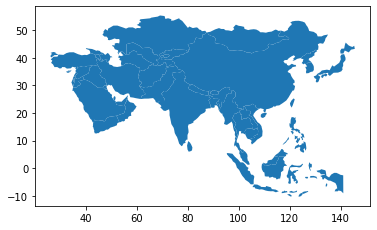

In [51]:
asia = world[world.continent == 'Asia']
asia = asia[['geometry','name']]

asia.plot()

convert to crs with meters

In [52]:
asia = asia.to_crs('epsg:3395')
capitals = capitals.to_crs('epsg:3395') 

make buffer from capitals - creating polygons from points, it is opposite to create centroids 

In [53]:
capitals['geometry'] = capitals.buffer(10000)
capitals.head()

,name,geometry
0,Vatican City,"POLYGON ((1396304.644 5117957.427, 1396256.491..."
1,San Marino,"POLYGON ((1395011.523 5425900.271, 1394963.370..."
2,Vaduz,"POLYGON ((1069390.803 5932596.005, 1069342.650..."
3,Lobamba,"POLYGON ((3483167.790 -3037957.646, 3483119.63..."
4,Luxembourg,"POLYGON ((692388.790 6346728.175, 692340.638 6..."


Intersection

<AxesSubplot: >

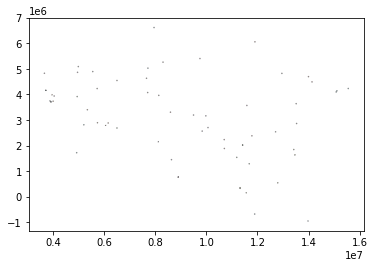

In [54]:
asia_cores = gpd.overlay(asia, capitals, how='intersection')
asia_cores.plot(alpha=0.5, edgecolor='k', cmap='tab10')

Difference: 

<AxesSubplot: >

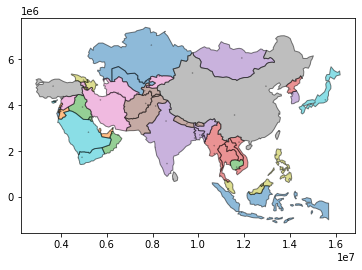

In [56]:
asia_peripheries = gpd.overlay(asia, capitals, how='difference')
asia_peripheries.plot(alpha=0.5, edgecolor='k', cmap='tab10')

#### 4. Nearest Neighbourhood

In [66]:
stations = pd.read_csv(f'{path}/data/bike_data/stations.csv') 
stations.head()

,id,name,dpcapacity,xcoord,ycoord
0,5,State St & Harrison St,19,-87.627739,41.873958
1,13,Wilton Ave & Diversey Pkwy,19,-87.652681,41.932500
2,14,Morgan St & 18th St,15,-87.651073,41.858086
3,15,Racine Ave & 19th St,15,-87.656471,41.856453
4,16,Wood St & North Ave,15,-87.672516,41.910329


In [67]:
points = pd.read_csv(f'{path}/data/bike_data/points.csv')

In [68]:
points.head()

,id,xcoord,ycoord
0,1,-87.675992,41.969792
1,2,-87.676702,41.956395
2,3,-87.601501,41.805379
3,4,-87.616656,41.858263
4,5,-87.706869,41.963010


In [69]:
def create_gdf(df, x='xcoord', y='ycoord'):
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]), crs='epsg:4329')

stations_gdf = create_gdf(df=stations)
points_gdf = create_gdf(df=points)

<AxesSubplot: >

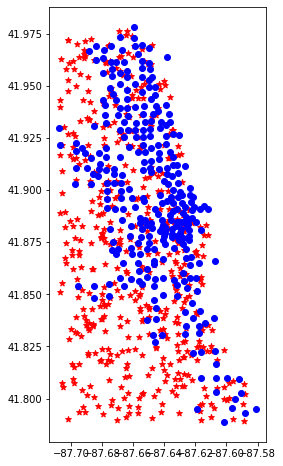

In [71]:
fig, ax = plt.subplots(figsize=(10,8))

points_gdf.plot(ax=ax, color='red', marker='*')
stations_gdf.plot(ax=ax, color='blue')

Red stars represents randomly generated points which we can understand as a people searching for closest station. And blue are stations. 

In [76]:
def calculate_nearest(row, destination, val, col='geometry'):
    
    #combines all the geometries 
    dest = destination['geometry'].unary_union
    nearest_geom = nearest_points(row[col], dest)
    
    match_geom = destination.loc[destination.geometry == nearest_geom[1]]
    match_value = match_geom[val].to_numpy()[0]
    return match_value

In [77]:
points_gdf['nearest_geom'] = points_gdf.apply(calculate_nearest, destination=stations_gdf, val='geometry', axis=1)

/opt/anaconda3/envs/spatial-ds-ws/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [78]:
points_gdf.head()

,id,xcoord,ycoord,geometry,nearest_geom
0,1,-87.675992,41.969792,POINT (-87.67599 41.96979),POINT (-87.67424 41.96909)
1,2,-87.676702,41.956395,POINT (-87.67670 41.95640),POINT (-87.67926 41.95593)
2,3,-87.601501,41.805379,POINT (-87.60150 41.80538),POINT (-87.59938 41.80983)
3,4,-87.616656,41.858263,POINT (-87.61666 41.85826),POINT (-87.61941 41.85761)
4,5,-87.706869,41.963010,POINT (-87.70687 41.96301),POINT (-87.68849 41.96655)


Adding a line to the closest point 

In [80]:
points_gdf['line'] = points_gdf.apply(lambda row: LineString([row.geometry, row.nearest_geom]), axis=1) 

/opt/anaconda3/envs/spatial-ds-ws/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [82]:
line_gdf = points_gdf[['id', 'nearest_geom', 'line']].set_geometry('line')

In [83]:
line_gdf.geometry

0      LINESTRING (-87.67599 41.96979, -87.67424 41.9...
1      LINESTRING (-87.67670 41.95640, -87.67926 41.9...
2      LINESTRING (-87.60150 41.80538, -87.59938 41.8...
3      LINESTRING (-87.61666 41.85826, -87.61941 41.8...
4      LINESTRING (-87.70687 41.96301, -87.68849 41.9...
                             ...                        
493    LINESTRING (-87.66327 41.92158, -87.66309 41.9...
494    LINESTRING (-87.68038 41.84712, -87.68511 41.8...
495    LINESTRING (-87.65710 41.92564, -87.65840 41.9...
496    LINESTRING (-87.66918 41.97626, -87.66836 41.9...
497    LINESTRING (-87.66973 41.89712, -87.66775 41.8...
Name: line, Length: 498, dtype: geometry

In [85]:
line_gdf.crs = 'epsg:4326'

<AxesSubplot: >

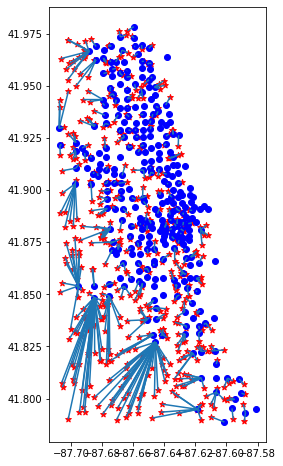

In [86]:
fig, ax = plt.subplots(figsize=(10,8))

points_gdf.plot(ax=ax, color='red', marker='*')
stations_gdf.plot(ax=ax, color='blue')
line_gdf.plot(ax=ax)